# Table of Contents
1. [Introduction](#introduction)
  1. [Using the notebook](#using-the-notebook)
2. [Guided Example](#guided-example)
  1. [Example image selection](#example-image-selection)
  2. [Image pre-processing](#image-pre-processing)
  3. [Detection and Drawing](#detection-and-drawing)
  4. [Widgets](#widgets)
3. [Image Upload](#image-upload)

# Introduction <a class="anchor" id="introduction"></a>
This notebook allows you to upload an image and explore how a machine learning algorithm detects faces within the image. First, I've written a brief guide using an example image that shows how all the significant pieces come together. I've included a few different example images to choose from.

The example is followed by a single notebook cell provides the user upload feature. This cell is designed to be able to be used whether or not the example code has be run and therefore contains much of the example code as well.

### Using the Notebook <a class="anchor" id="using-the-notebook"></a>
To execute a cell, click on it and either press ```Shift + Enter``` or click the 'Run' button in the toolbar above. The cells are meant to be executed sequentially.

After a cell is run, the ```In []:``` to the left of the cell should change to ```In [some number]:```.

If you want to make an output window larger so you don't have to scroll, single-click in the white margin to the left of the cell.

#TODO ADD screenshot here

If you get any errors, check to make sure each cell has been executed. Otherwise, try reseting the kernel and running the cells again. To reset the kernel, click ```Kernel > Restart & Clear Output``` in the toolbar above.


You can find more information about the notebook environment and how to troubleshoot issues [here](https://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb).

# Guided Example <a class="anchor" id="guided-example"></a>

### Example image selection <a class="anchor" id="example-image-selection"></a>

There are four images of faces provided with Example 4 being of cartoon faces. All of the provided images are of clear frontal shots of faces as the model chosen here is best suited for this task; models for detecting other objects can be found [here](https://github.com/opencv/opencv/tree/3.4/data).

Interestingly, the snippet below serves as a kind of vertical slice since it nicely display the motif that the rest of the code follows.

In [1]:
# Run this cell first

import os
import cv2 as cv
import ipywidgets as widgets
import numpy as np
from PIL import Image, ImageDraw

CASCADE = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

example_selector = widgets.Dropdown(
    options=[
        ('Select an image...', 0), 
        ('Example 1', 'test_faces0.jpeg'), 
        ('Example 2', 'test_faces1.jpeg' ), 
        ('Example 3', 'test_faces3.jpeg'), 
        ('Example 4', 'test_faces_cartoon.jpg')
    ],
    value=0,
)
widget_output = widgets.Output() # capture widget output for display

def handle_selection(change):
    with widget_output:
        try:
            path = os.path.join('test_images', change['new'])
            example_img = Image.open(path)
            display(example_img)
        except TypeError:
            print('Please select an example image.')
    widget_output.clear_output(wait=True) # clear previous output when new output is displayed
    
example_selector.observe(handle_selection, names='value')

widgets.VBox([widgets.Label('Select an example image'), example_selector, widget_output])

### Image pre-processing <a class="anchor" id="image-pre-processing"></a>

Before much can be done, the example image will need to be converted into a couple differnt formats:

 - **PIL image object:** PIL is used to both draw on and display the image. While PIL and OpenCV both have drawing capability, I mainly chose to use PIL because it doesn't create a pop-up window to display the image. 
 

 - **Grayscale image:** The detection model requires a grayscale image format, which is just a 2-D array of 8-bit integers. For this, a 1-D numpy array is created from the image's bytestring, which is in turn converted to the grayscale image.

In [4]:
# Cell 2 (this cell doesn't have output)

EXAMPLE_PATH = os.path.join('test_images', example_selector.value)

with open(EXAMPLE_PATH, 'rb') as f:    
    img_bytestring = f.read()
    
pil_img = Image.open(EXAMPLE_PATH) # PIL image object for drawing
np_array = np.frombuffer(img_bytestring, dtype=np.uint8) # convert bytestring to 1-D array (intermediate)
grayscale = cv.imdecode(np_array, cv.IMREAD_GRAYSCALE) # convert 1-D array to 2-D array for detection

### Detection and drawing <a class="anchor" id="detection-and-drawing"></a>
Now that the image has been processed, faces can be detected. The detection function returns detected faces as (x, y, w, h), where x and y are the coordinates of the top-left corner. From there, boxes can be drawn around on a copy of the image to preserve the original image.

Take note of the ```scale_factor``` and ```min_neighbors``` parameters in ```CASCADE.detectMultiScale()```; these parameters allow the sensitivity of the model to be adjusted and will be hooked up to widgets in the next step.

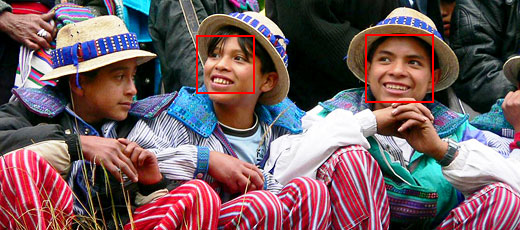

In [5]:
# Cell 3

def draw_faces(scale_factor, min_neighbors):
    detected_faces = CASCADE.detectMultiScale(grayscale, scale_factor, min_neighbors)
    
    img_copy = pil_img.copy()
    draw_context = ImageDraw.Draw(img_copy)
    
    for face in detected_faces:
        draw_context.rectangle((face[0],face[1],face[0]+face[2],face[1]+face[3]), outline='red', width=2)
    return img_copy

draw_faces(1.05, 3) # use default values

### Widgets <a class="anchor" id="widgets"></a>
The detection function will need to be re-run everytime the ```scale_factor``` or ```min_neighbors``` widget is changes. This can be done way of event handlers. 

The Ipywidgets library has a ```widget.observe()``` method that allows a user-defined function to be called every time the widget is used. This observer function mandates that the callable accept a dictionary containing all the information about the widget's changes.

In [9]:
# Cell 4

# widgets
scale_slider = widgets.FloatSlider(
    value=1.05, 
    min=1.05,  # must be >=1.01; set to default CASCADE.detectMultiScale() scaleFactor argument
    max=1.50,
    step=0.05,
    description='Scale Factor',
    continuous_update=False,  # debounce
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
neighbor_slider = widgets.IntSlider(
    value=3,  # set default slider value to default CASCADE.detectMultiScale() minNeighbors argument
    min=1,
    max=10,
    step=1,
    description='Neighbors',
    continuous_update=False,  # debounce
    orientation='horizontal',
    readout=True
)
widget_output = widgets.Output() 

# handler functions for widets
def handle_scale_slider(change):
    with widget_output:
        display(draw_faces(change['new'], neighbor_slider.value))
    widget_output.clear_output(wait=True)
    
def handle_neighbor_slider(change):
    with widget_output:  
        display(draw_faces(scale_slider.value, change['new']))
    widget_output.clear_output(wait=True)
    
scale_slider.observe(handle_scale_slider, names='value')
neighbor_slider.observe(handle_neighbor_slider, names='value')
    
# display widgets, output
display(widgets.VBox([widgets.Label('Upload an image.'),
              scale_slider, neighbor_slider, widget_output]))

# display example image with no boxes drawn first
with widget_output:   
    displapil_img)
widget_output.clear_output(wait=True)

# Image Upload <a class="anchor" id="image-upload"></a>

The cell below allows for detection to be used on an uploaded image.

Simply run the cell below and use the upload button to run face detection on an image.

The sensitivity of the model can be changed using the ```Scale Factor``` and ```Neighbors``` sliders.

In [ ]:
# Run this cell for the upload feature. 

import io

import cv2 as cv
import ipywidgets as widgets
import numpy as np
from PIL import Image, ImageDraw

CASCADE = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

uploader = widgets.FileUpload(button_style='info')
scale_slider = widgets.FloatSlider(
    value=1.05, 
    min=1.05,  # must be >=1.01; set to default CASCADE.detectMultiScale() scaleFactor argument
    max=1.50,
    step=0.05,
    description='Scale Factor',
    continuous_update=False,  # debounce
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)
neighbor_slider = widgets.IntSlider(
    value=3,  # set default slider value to default CASCADE.detectMultiScale() minNeighbors argument
    min=1,
    max=10,
    step=1,
    description='Neighbors',
    continuous_update=False,  # debounce
    orientation='horizontal',
    readout=True
)
widget_output = widgets.Output()

def get_upload_formats():
    """Return PIL and grayscale formats from uploaded image bytestring."""
    img_bytestring = uploader.data[0]  
    pil_img = Image.open(io.BytesIO(img_bytestring))
    np_array = np.frombuffer(img_bytestring, dtype=np.uint8)
    grayscale = cv.imdecode(np_array, cv.IMREAD_GRAYSCALE)
    formats = {"pil_img": pil_img, "grayscale": grayscale}
    return formats

def draw_faces(scale_factor, min_neighbors):
    """Detect faces and return copy of image with boxes drawn around faces."""
    formats = get_upload_formats()
    detected_faces = CASCADE.detectMultiScale(formats['grayscale'], scale_factor, min_neighbors)
    
    img_copy = formats['pil_img'].copy()
    draw_context = ImageDraw.Draw(img_copy)
    
    for face in detected_faces:
        draw_context.rectangle((face[0],face[1],face[0]+face[2],face[1]+face[3]), outline='red', width=2)
    return img_copy 

def handle_scale_slider(change):
    """Call draws_faces() and display results when scale_factor_slider is changed."""
    with widget_output:
        try: 
            display(draw_faces(change['new'], neighbor_slider.value))
        except IndexError: # handle slider movement w/o upload
            display('Please upload an image first.')
    widget_output.clear_output(wait=True)
    
def handle_neighbor_slider(change):
    """Call draws_faces() and display results when min_neighbors_slider is changed."""
    with widget_output:
        try:      
            display(draw_faces(scale_slider.value, change['new']))
        except IndexError: # handle slider movement w/o upload
            display('Please upload an image first.')
    widget_output.clear_output(wait=True)
    
def handle_upload(change):
    """Call draws_faces() and display results when image is uploaded."""
    scale_slider.value = 1.05
    neighbor_slider.value = 3
    
    with widget_output:
        try: 
            display(draw_faces(scale_slider.value, neighbor_slider.value))
        except Image.UnidentifiedImageError: # handle upload of non-image file
            display("Please upload an image file."")
    widget_output.clear_output(wait=True)
      
uploader.observe(handle_upload, names='_counter')
scale_slider.observe(handle_scale_slider, names='value')
neighbor_slider.observe(handle_neighbor_slider, names='value')

widgets.VBox([widgets.Label('Upload an image.'),
              uploader, scale_slider, neighbor_slider, widget_output])